In [ ]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
plt.rcParams["figure.figsize"] = [6,6]

In [18]:
class GridEnvironment(gym.Env):
    
    def __init__(self):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 10
        self.timestep = 0
        self.end = False
        
        self.pos = {'knight':[3,0],
                   'mon1':[1,2],
                   'mon2':[2,1],
                   'chest':[0,3],
                   'coin1':[3,1],
                   'coin2':[1,3]}
        
        self.state = np.zeros((4,4))
        self.state[tuple(self.pos['knight'])] = 1
        self.state[tuple(self.pos['mon1'])] = 2
        self.state[tuple(self.pos['mon2'])] = 2
        self.state[tuple(self.pos['chest'])] = 3
        self.state[tuple(self.pos['coin1'])] = 4
        self.state[tuple(self.pos['coin1'])] = 4
        self.mon1_death = False
        self.mon2_death = False
        self.coin1_collected = False
        self.coin2_collected = False
        
        # loading assets for rendering
        
        chars = mpimg.imread('Dungeon_Character.png')
        tiles = mpimg.imread('Dungeon_Tileset.png')
        assets = {}
        assets['knight'] = chars[:16,16*5:16*6]
        assets['mon1'] = chars[16:,16*6:]
        assets['mon2'] = chars[16:,16*5:16*6]
        assets['chest'] = tiles[16*8:16*9,16*4:16*5]
        assets['bones'] = tiles[16*7:16*8,16*7:16*8]
        torch = tiles[16*9:,:16]
        assets['coin1'] = tiles[16*8:16*9,16*6:16*7]
        assets['coin2'] = assets['coin1']
        stage = np.concatenate((tiles[:16*3,:16*6],
                                np.flip(tiles[16*2:16*3,:16*6],axis=1),
                                tiles[16*3:16*5,:16*6]),axis=0)
        stage[:16,16:16*2] = np.where(torch != 0,torch,stage[:16,16:16*2])
        stage[:16,16*4:16*5] = np.where(torch != 0,torch,stage[:16,16*4:16*5])
        self.stage = stage
        self.assets = assets
        self.archive = []

    def reset(self):
        self.timestep = 0
        self.pos = {'knight':[3,0],
                   'mon1':[1,2],
                   'mon2':[2,1],
                   'chest':[0,3],
                   'coin1':[3,1],
                   'coin2':[1,3]}
        
        self.state = np.zeros((4,4))
        self.state[tuple(self.pos['knight'])] = 1
        self.state[tuple(self.pos['mon1'])] = 2
        self.state[tuple(self.pos['mon2'])] = 2
        self.state[tuple(self.pos['chest'])] = 3
        self.state[tuple(self.pos['coin1'])] = 4
        self.state[tuple(self.pos['coin2'])] = 4
        
        observation = self.state.flatten()
        return observation
    
    def step(self, action, stochastic = False):
        '''
        0 - up
        1 - down
        2 - right
        3 - left
        '''
        if action == 0:
          self.pos['knight'][0] += 1
        elif action == 1:
          self.pos['knight'][0] -= 1
        elif action == 2:
          self.pos['knight'][1] += 1
        elif action == 3:
          self.pos['knight'][1] -= 1

        self.pos['knight'] = list(np.clip(self.pos['knight'], 0, 3))
        
        self.state = np.zeros((4,4))
        self.state[tuple(self.pos['knight'])] = 1
        self.state[tuple(self.pos['mon1'])] = 2
        self.state[tuple(self.pos['mon2'])] = 2
        self.state[tuple(self.pos['chest'])] = 3
        self.state[tuple(self.pos['coin1'])] = 4
        self.state[tuple(self.pos['coin1'])] = 4        
        observation = self.state.flatten()
        
        reward = 0
        if self.pos['knight'] == self.pos['chest']:
            reward = 1
            self.end = True
            print('swimming in gold')
        elif self.pos['knight'] == self.pos['mon1']:
            if self.mon1_death:
                pass
            else:
                reward = -0.5
                self.mon1_death = True
                
        elif self.pos['knight'] == self.pos['mon2']:
            if self.mon2_death:
                pass
            else:
                reward = -0.5
                self.mon2_death = True
        elif self.pos['knight'] == self.pos['coin1']:
            if self.coin1_collected:
                pass
            else:
                reward = 0.5
                self.coin1_collected = True
        elif self.pos['knight'] == self.pos['coin2']:
            if self.coin2_collected:
                pass
            else:
                reward = 0.5
                self.coin2_collected = True
        
        self.timestep += 1
        if self.timestep == self.max_timesteps:
            self.end = True
        return observation, reward
    
    def play(self,mode='random'):
        if mode == 'random':
            while not self.end:
                x = np.random.randint(0, 4)
                observation,reward = self.step(x)
                self.archive.append(self.project())
        
    def project(self):
        instance = np.copy(self.stage)
        for item in ['mon1','mon2','chest','coin1','coin2','knight']:
            item_asset = item
            if item == 'mon1' and self.mon1_death:
                item_asset = 'bones'
            elif item == 'mon2' and self.mon2_death:
                item_asset = 'bones'
            elif item == 'coin1' and self.coin1_collected:
                continue
            elif item == 'coin2' and self.coin2_collected:
                continue
            x = np.where(self.assets[item_asset] != 0, self.assets[item_asset], 
                       instance[16*(self.pos[item][0]+1):16*(self.pos[item][0]+2),
                                16*(self.pos[item][1]+1):16*(self.pos[item][1]+2)])
            instance[16*(self.pos[item][0]+1):16*(self.pos[item][0]+2),
                     16*(self.pos[item][1]+1):16*(self.pos[item][1]+2)] = x
        return instance
    
    def render(self):
        instance = self.project()
        
        plt.axis('off')
        plt.imshow(instance,interpolation='none',aspect='equal')
        
    def timeline(self):
        for instance in self.archive:
            plt.figure()
            plt.axis('off')
            plt.imshow(instance)
        

In [21]:
env = GridEnvironment()
env.play()

swimming in gold


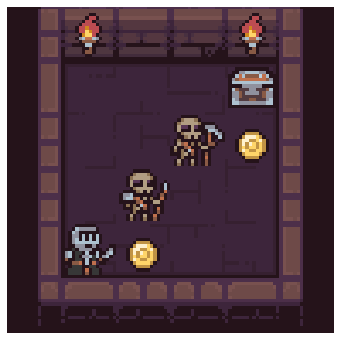

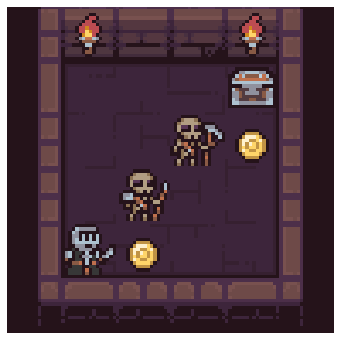

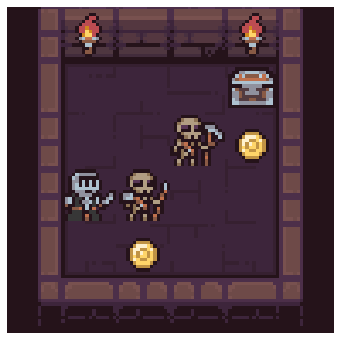

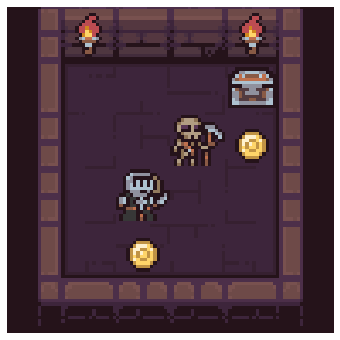

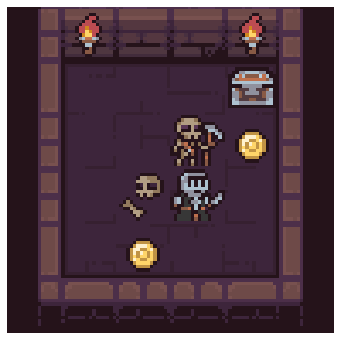

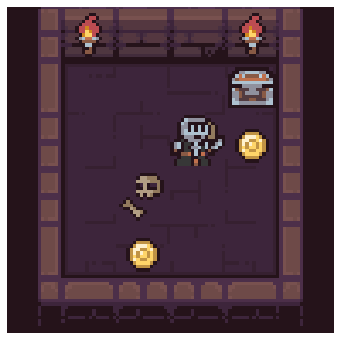

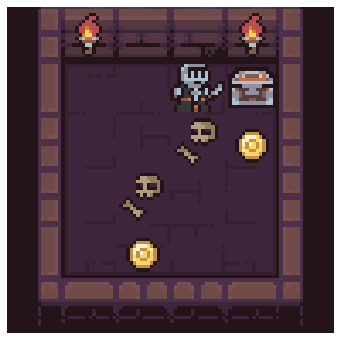

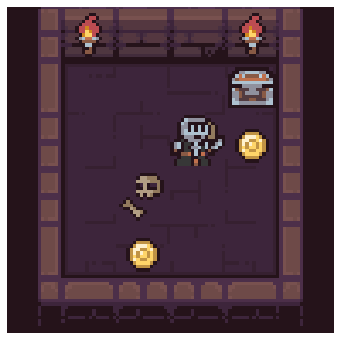

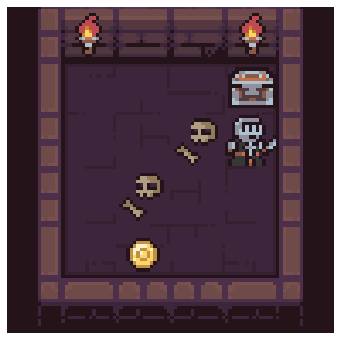

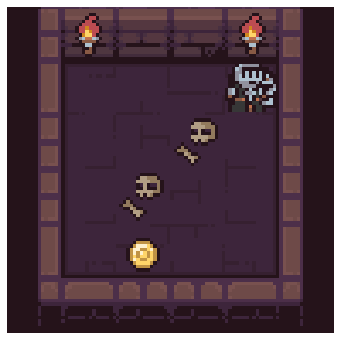

In [22]:
env.timeline()